# 207 Final Project

The final project consists of classifying heartbeat sound bassed on 4 types of categories: murmur, normal, artifact, and other. The dataset can be found at: https://www.kaggle.com/datasets/kinguistics/heartbeat-sounds on Kaggle. 

This project will explore how to convert audio files into full spectrograms and then find common patterns amongst these spectrograms.

In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

from IPython.display import Audio
from scipy.io import wavfile
import wave
import librosa
import soundfile as sf

from tqdm import tqdm

from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPool1D, MaxPool2D, GlobalAvgPool1D, Dropout, BatchNormalization, Dense, LSTM, Flatten, concatenate
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.regularizers import l2
from keras.layers import Lambda 
from keras import backend as K 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import KFold

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras import layers

## Data Exploration

The following code was used to help identifiy commonalities and differences in the data. In this step, the data is analyzed for its sample rate, channels, labels and the name of the clips.

In [2]:
audio_path = 'DHD/audio/'
audio_files = os.listdir(audio_path)

# Initialize lists to store data
clip_names = []
durations = []
sample_rates = []
num_channels = []
labels = []

# Loop through all files and collect data
for file in audio_files:
    # Only process .wav files
    if file.endswith('.wav'):
        path = os.path.join(audio_path, file)
        y, sr = librosa.load(path, sr=None, mono=False)
        
        # Get duration and number of channels
        duration = librosa.get_duration(y=y, sr=sr)
        if y.ndim > 1:  # Check if audio is not mono
            n_channels = y.shape[0]
        else:
            n_channels = 1
        
        # Append data to lists
        clip_names.append(file)
        durations.append(duration)
        sample_rates.append(sr)
        num_channels.append(n_channels)
        
        # Label the clip based on its name
        if 'normal' in file.lower():
            labels.append('normal')
        elif 'murmur' in file.lower():
            labels.append('murmur')
        elif 'extrahls' in file.lower():
            labels.append('extrahls')
        else:
            labels.append('other')

# Create a DataFrame with the collected data
audio_df = pd.DataFrame({
    'Clip Name': clip_names,
    'Duration': durations,
    'Sample Rate': sample_rates,
    'Channels': num_channels,
    'Label': labels
})

# Display the DataFrame
audio_df

,Clip Name,Duration,Sample Rate,Channels,Label
0,artifact_2023_17.wav,20.458667,48000,2,other
1,normal__201108011112.wav,7.935556,44100,1,normal
2,artifact__201012172012.wav,9.000000,44100,1,other
3,normal__232_1308748524018_D1.wav,1.681000,4000,1,normal
4,extrahls__201104140118.wav,1.947392,44100,1,extrahls
...,...,...,...,...,...
656,normal_noisynormal_270_1309369533040_A.wav,10.665250,4000,1,normal
657,artifact_2023_32.wav,4.928000,48000,2,other
658,artifact__201106061233.wav,9.000000,44100,1,other
659,normal_noisynormal_123_1306331925797_C.wav,8.256750,4000,1,normal


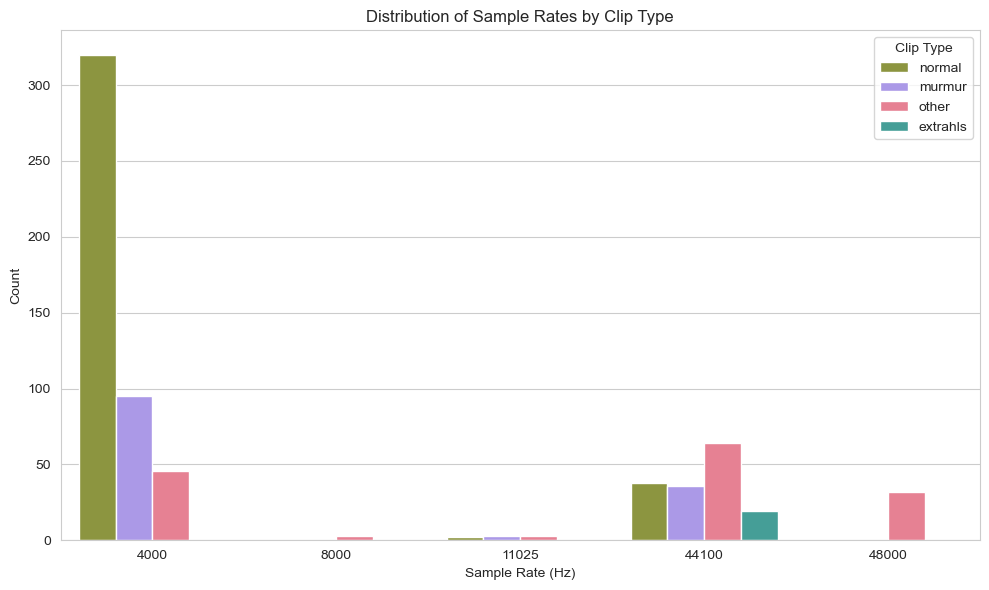

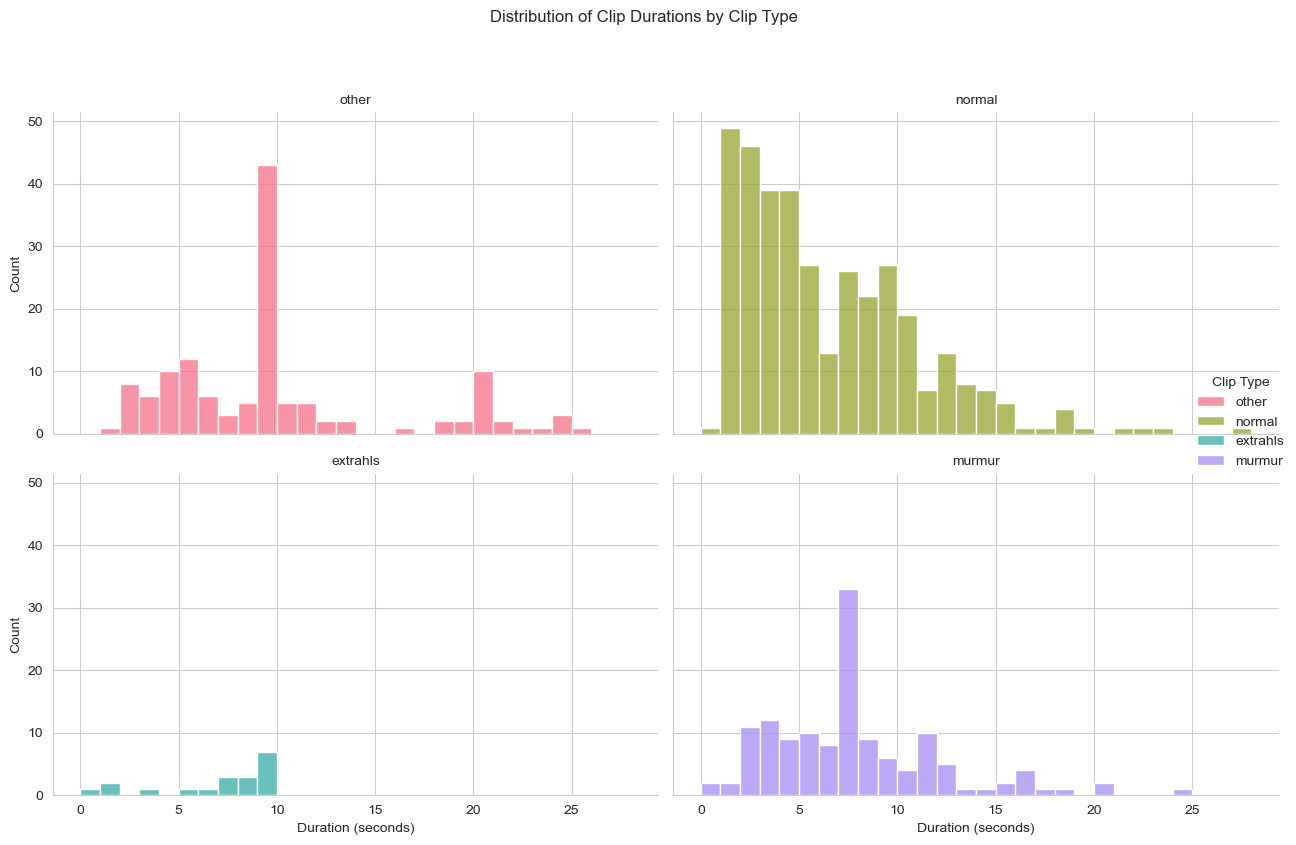

In [3]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Define a color palette that matches the number of unique labels
unique_labels = audio_df['Label'].unique()
palette = sns.color_palette("husl", len(unique_labels))
label_palette = dict(zip(unique_labels, palette))

# Plot the distribution of sample rates by clip type with the defined palette
plt.figure(figsize=(10, 6))
sns.countplot(data=audio_df, x='Sample Rate', hue='Label', palette=label_palette)
plt.title('Distribution of Sample Rates by Clip Type')
plt.xlabel('Sample Rate (Hz)')
plt.ylabel('Count')
plt.legend(title='Clip Type')
plt.tight_layout()
plt.show()

# Ensure durations are binned
audio_df['Duration Bin'] = pd.cut(audio_df['Duration'], bins=np.arange(0, 31, 1), right=False)
audio_df['Duration Bin Mid'] = audio_df['Duration Bin'].apply(lambda x: x.mid)

# Create a FacetGrid with data, specifying the 'col' for side-by-side and 'col_wrap' to control the number of columns
g = sns.FacetGrid(audio_df, col="Label", hue="Label", col_wrap=2, height=4, aspect=1.5, palette=label_palette)

# Map the histplot to each subplot
g.map(sns.histplot, "Duration Bin Mid", bins=np.arange(0, 31, 1), kde=False, binwidth=0.9)

# Set titles, labels, and adjust layout
g.set_titles("{col_name}")
g.set_axis_labels("Duration (seconds)", "Count")
g.fig.suptitle('Distribution of Clip Durations by Clip Type', y=1.05)
g.add_legend(title="Clip Type")

plt.tight_layout()
plt.show()

The vast majority of this sample was normal and artifacts. 

In [4]:
print("Dataframe Stats:")
display(audio_df.describe())

duration_stats_by_label = audio_df.groupby('Label')['Duration'].describe()
print("Duration Stats by Label:")
display(duration_stats_by_label)

sample_rate_stats_by_label = audio_df.groupby('Label')['Sample Rate'].describe()
print("Sample Rate Stats by Label:")
display(sample_rate_stats_by_label)

Dataframe Stats:


,Duration,Sample Rate,Channels
count,661.000000,661.000000,661.000000
mean,9.066489,15757.791225,1.083207
std,13.263693,18400.922135,0.276404
min,0.763250,4000.000000,1.000000
25%,3.618500,4000.000000,1.000000
50%,7.393500,4000.000000,1.000000
75%,9.770750,44100.000000,1.000000
max,209.999958,48000.000000,2.000000


Duration Stats by Label:


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
extrahls,19.0,6.872237,2.806419,0.936372,6.061406,8.013923,9.000000,9.000000
murmur,134.0,7.904781,4.314600,0.856750,4.706405,7.935556,9.615875,24.160000
normal,360.0,6.631615,5.558905,0.763250,2.943563,5.120250,9.000000,69.125805
other,148.0,16.322668,25.044240,1.874500,6.343438,9.000000,19.093333,209.999958


Sample Rate Stats by Label:


,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
extrahls,19.0,44100.000000,0.000000,44100.0,44100.0,44100.0,44100.0,44100.0
murmur,134.0,14930.410448,17776.158941,4000.0,4000.0,4000.0,44100.0,44100.0
normal,360.0,8271.805556,12336.246057,4000.0,4000.0,4000.0,4000.0,44100.0
other,148.0,31077.533784,19613.294147,4000.0,4000.0,44100.0,44100.0,48000.0


## Standardize Audio Files and Resample

In order to analyze the spectrograms for each of the files, we must standardize every file to ensure the proper sample rate, length, and channels match up. Here, we force all the sample rates to be no longer than 15 seconds. if it is shorter than 15 seconds, it will repeat the audio until it is 15 seconds. If it is larger than 15 seconds, the audio is clipped. All the channels have been forced to be 1. 

In [5]:
def standardize_duration_and_resample(file_path, target_sr=16000, target_duration=15, save_path='DHD/audio/processed_resampled/'):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=None, mono=False)

    # Convert to mono if the audio is stereo
    if audio.ndim > 1:
        audio = librosa.to_mono(audio)

    # Resample the audio if the original sample rate is not the same as the target sample rate
    if sr != target_sr:
        print(f"Resampling from {sr} Hz to {target_sr} Hz.")
        audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
    else:
        print("Original sample rate matches the target. No resampling needed.")

    # Calculate the number of samples needed for the target duration
    target_samples = int(target_sr * target_duration)

    # Truncate or loop the audio to match the target duration
    if len(audio) < target_samples:
        # Loop the audio until it reaches the target duration
        n_repeats = int(np.ceil(target_samples / len(audio)))
        audio = np.tile(audio, n_repeats)[:target_samples]
    else:
        # Truncate the audio to the target duration
        audio = audio[:target_samples]

    # Ensure the save path directory exists
    os.makedirs(save_path, exist_ok=True)

    # Extract the filename and prepare the save filename
    filename = os.path.basename(file_path)
    save_filename = os.path.join(save_path, filename)

    # Save the resampled and duration-standardized audio
    sf.write(file=save_filename, data=audio, samplerate=target_sr)
    print(f"Processed audio saved to: {save_filename}")

    # Return the processed audio information
    return {
        'File Name': filename,
        'Duration (s)': target_duration,
        'Sample Rate (Hz)': target_sr,
        'Channels': 1
    }

In [6]:
audio_directory = 'DHD/audio/'

# Initialize an empty list to store the processed audio information
processed_audio_info = []

# Iterate over the files in the audio directory
for filename in os.listdir(audio_directory):
    if filename.endswith('.wav'):  # Adjust the file extension if needed
        audio_path = os.path.join(audio_directory, filename)
        audio_info = standardize_duration_and_resample(audio_path)
        processed_audio_info.append(audio_info)

# Create a DataFrame from the processed audio information
df = pd.DataFrame(processed_audio_info)

# Display the DataFrame
display(df)

Resampling from 48000 Hz to 16000 Hz.
Processed audio saved to: DHD/audio/processed_resampled/artifact_2023_17.wav
Resampling from 44100 Hz to 16000 Hz.
Processed audio saved to: DHD/audio/processed_resampled/normal__201108011112.wav
Resampling from 44100 Hz to 16000 Hz.
Processed audio saved to: DHD/audio/processed_resampled/artifact__201012172012.wav
Resampling from 4000 Hz to 16000 Hz.
Processed audio saved to: DHD/audio/processed_resampled/normal__232_1308748524018_D1.wav
Resampling from 44100 Hz to 16000 Hz.
Processed audio saved to: DHD/audio/processed_resampled/extrahls__201104140118.wav
Resampling from 4000 Hz to 16000 Hz.
Processed audio saved to: DHD/audio/processed_resampled/normal__184_1308073010307_D.wav
Resampling from 4000 Hz to 16000 Hz.
Processed audio saved to: DHD/audio/processed_resampled/normal_noisynormal_109_1305653972028_F.wav
Resampling from 4000 Hz to 16000 Hz.
Processed audio saved to: DHD/audio/processed_resampled/normal_noisynormal_264_1309356143724_B.wav
R

,File Name,Duration (s),Sample Rate (Hz),Channels
0,artifact_2023_17.wav,15,16000,1
1,normal__201108011112.wav,15,16000,1
2,artifact__201012172012.wav,15,16000,1
3,normal__232_1308748524018_D1.wav,15,16000,1
4,extrahls__201104140118.wav,15,16000,1
...,...,...,...,...
656,normal_noisynormal_270_1309369533040_A.wav,15,16000,1
657,artifact_2023_32.wav,15,16000,1
658,artifact__201106061233.wav,15,16000,1
659,normal_noisynormal_123_1306331925797_C.wav,15,16000,1


In [7]:
def pad_spectrogram(spectrogram, target_shape, mode='constant'):
    pad_width = [(0, 0)]  # No padding in the frequency axis
    pad_width.append((0, target_shape[1] - spectrogram.shape[1]))  # Pad in the time axis
    return np.pad(spectrogram, pad_width, mode=mode)


def create_spectrograms(file_path):
    # Load the audio file with the specified sample rate
    audio, sr = librosa.load(file_path, sr=16000, mono=True, duration=15)

    # Spectrogram parameters
    window_size = 0.03  # 30 ms window (use a slightly larger window to get closer to 1000 frames)
    window_hop = 0.005  # 5 ms hop
    n_fft = int(sr * window_size)  # FFT size calculated from sample rate and window size
    hop_length = int(sr * window_hop)  # Hop length calculated from sample rate and hop size

    # Calculate mel filterbank based on the frequency range and FFT size
    n_mels = 128
    fmin = 10
    fmax = 1000
    mel_filterbank = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels, fmin=fmin, fmax=fmax)

    # Generate the full spectrogram using STFT
    spectrogram_stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length, window='hann')
    spectrogram_stft_db = librosa.amplitude_to_db(abs(spectrogram_stft))

    # Generate the Mel spectrogram
    mel_spectrogram = np.dot(mel_filterbank, abs(spectrogram_stft))
    mel_spectrogram_db = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)

    # Stabilized log mel spectrogram
    log_mel_spectrogram_db = librosa.amplitude_to_db(mel_spectrogram + 0.01, ref=np.max)

    # Generate the harmonic spectrogram (same parameters as STFT)
    harmonic_spectrogram = librosa.effects.harmonic(audio)
    harmonic_spectrogram_stft = librosa.stft(harmonic_spectrogram, n_fft=n_fft, hop_length=hop_length, window='hann')
    harmonic_spectrogram_db = librosa.amplitude_to_db(abs(harmonic_spectrogram_stft))

    # Generate the percussive spectrogram (same parameters as STFT)
    percussive_spectrogram = librosa.effects.percussive(audio)
    percussive_spectrogram_stft = librosa.stft(percussive_spectrogram, n_fft=n_fft, hop_length=hop_length, window='hann')
    percussive_spectrogram_db = librosa.amplitude_to_db(abs(percussive_spectrogram_stft))

    # Padding to reach a shape of (1000, *)
    target_shape = (1000, spectrogram_stft_db.shape[1])  # Adjust as needed if a different time-dimension is required

    # Calculate exact padding needed
    for spectrogram in [spectrogram_stft_db, log_mel_spectrogram_db, harmonic_spectrogram_db, percussive_spectrogram_db]:
        pad_width = [(0, 0), (0, target_shape[1] - spectrogram.shape[1])]
        spectrogram = np.pad(spectrogram, pad_width, mode='constant')

    return spectrogram_stft_db, log_mel_spectrogram_db, harmonic_spectrogram_db, percussive_spectrogram_db

In [8]:
# Specify the directory containing the processed audio files
processed_audio_directory = 'DHD/audio/processed_resampled/'

# Load the CSV file containing the filename-label mapping
label_data = pd.read_csv('DHD/labels.csv')

# Initialize empty lists to store the spectrograms and labels
spectrograms_stft = []
spectrograms_mel = []
spectrograms_harmonic = []
spectrograms_percussive = []
labels_list = []  # Use a list to collect labels

# Get the total number of files for progress tracking
total_files = len([filename for filename in os.listdir(processed_audio_directory) if filename.endswith('.wav')])

# Iterate over the files in the processed audio directory with a progress bar
for filename in tqdm(os.listdir(processed_audio_directory), desc='Processing audio files', total=total_files):
    if filename.endswith('.wav'):
        audio_path = os.path.join(processed_audio_directory, filename)
        
        # Create multiple spectrograms for the audio file
        spectrogram_stft, mel_spectrogram, harmonic_spectrogram, percussive_spectrogram = create_spectrograms(audio_path)
        spectrograms_stft.append(spectrogram_stft)
        spectrograms_mel.append(mel_spectrogram)
        spectrograms_harmonic.append(harmonic_spectrogram)
        spectrograms_percussive.append(percussive_spectrogram)
        
        # Extract the label from the CSV file
        label_str = label_data.loc[label_data['filename'] == filename, 'label'].values[0]
        labels_list.append(label_str)

# Convert the spectrograms and labels to numpy arrays
spectrograms_stft = np.array(spectrograms_stft)
spectrograms_mel = np.array(spectrograms_mel)
spectrograms_harmonic = np.array(spectrograms_harmonic)
spectrograms_percussive = np.array(spectrograms_percussive)
labels = np.array(labels_list)

# Tokenize the labels using LabelEncoder
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Upsample the minority classes using resample from sklearn.utils for each spectrogram type
upsampled_spectrograms_stft = []
upsampled_spectrograms_mel = []
upsampled_spectrograms_harmonic = []
upsampled_spectrograms_percussive = []
upsampled_labels = []

for label in np.unique(labels_encoded):
    class_indices = np.where(labels_encoded == label)[0]
    class_spectrograms_stft = spectrograms_stft[class_indices]
    class_spectrograms_mel = spectrograms_mel[class_indices]
    class_spectrograms_harmonic = spectrograms_harmonic[class_indices]
    class_spectrograms_percussive = spectrograms_percussive[class_indices]
    class_labels = labels_encoded[class_indices]

    if len(class_indices) < len(labels_encoded) // len(np.unique(labels_encoded)):
        # Minority class, upsample
        upsampled_stft = resample(class_spectrograms_stft,
                                  replace=True,
                                  n_samples=len(labels_encoded) // len(np.unique(labels_encoded)),
                                  random_state=42)
        upsampled_mel = resample(class_spectrograms_mel,
                                 replace=True,
                                 n_samples=len(labels_encoded) // len(np.unique(labels_encoded)),
                                 random_state=42)
        upsampled_harmonic = resample(class_spectrograms_harmonic,
                                      replace=True,
                                      n_samples=len(labels_encoded) // len(np.unique(labels_encoded)),
                                      random_state=42)
        upsampled_percussive = resample(class_spectrograms_percussive,
                                        replace=True,
                                        n_samples=len(labels_encoded) // len(np.unique(labels_encoded)),
                                        random_state=42)
        upsampled_labels_class = np.full(len(upsampled_stft), label)
        upsampled_spectrograms_stft.append(upsampled_stft)
        upsampled_spectrograms_mel.append(upsampled_mel)
        upsampled_spectrograms_harmonic.append(upsampled_harmonic)
        upsampled_spectrograms_percussive.append(upsampled_percussive)
        upsampled_labels.append(upsampled_labels_class)
    else:
        # Majority class, keep as is
        upsampled_spectrograms_stft.append(class_spectrograms_stft)
        upsampled_spectrograms_mel.append(class_spectrograms_mel)
        upsampled_spectrograms_harmonic.append(class_spectrograms_harmonic)
        upsampled_spectrograms_percussive.append(class_spectrograms_percussive)
        upsampled_labels.append(class_labels)

upsampled_spectrograms_stft = np.concatenate(upsampled_spectrograms_stft)
upsampled_spectrograms_mel = np.concatenate(upsampled_spectrograms_mel)
upsampled_spectrograms_harmonic = np.concatenate(upsampled_spectrograms_harmonic)
upsampled_spectrograms_percussive = np.concatenate(upsampled_spectrograms_percussive)
upsampled_labels = np.concatenate(upsampled_labels)

# Randomize the order of the upsampled dataset
indices = np.arange(len(upsampled_labels))
np.random.shuffle(indices)
upsampled_spectrograms_stft = upsampled_spectrograms_stft[indices]
upsampled_spectrograms_mel = upsampled_spectrograms_mel[indices]
upsampled_spectrograms_harmonic = upsampled_spectrograms_harmonic[indices]
upsampled_spectrograms_percussive = upsampled_spectrograms_percussive[indices]
upsampled_labels = upsampled_labels[indices]

# Split the dataset into training and validation sets
train_spectrograms_stft, val_spectrograms_stft, train_spectrograms_mel, val_spectrograms_mel, \
train_spectrograms_harmonic, val_spectrograms_harmonic, train_spectrograms_percussive, val_spectrograms_percussive, \
train_labels, val_labels = train_test_split(
    upsampled_spectrograms_stft, upsampled_spectrograms_mel, upsampled_spectrograms_harmonic, upsampled_spectrograms_percussive,
    upsampled_labels, test_size=0.2, random_state=42)

Processing audio files:   0%|          | 0/661 [00:00<?, ?it/s]/var/folders/22/zrqyj3193lldgfwh8lh_tjn00000gn/T/ipykernel_48684/3563880702.py:21: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_filterbank = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels, fmin=fmin, fmax=fmax)
Processing audio files: 662it [06:58,  1.58it/s]                         


In [9]:
print(upsampled_spectrograms_stft.shape)
print(upsampled_spectrograms_mel.shape)
print(upsampled_spectrograms_harmonic.shape)
print(upsampled_spectrograms_percussive.shape)

(900, 241, 3001)
(900, 128, 3001)
(900, 241, 3001)
(900, 241, 3001)


## Building and Training Base Model
The baseline model was taken from HW5. Since this is a multi-class classification problem, we're using a multi-class classification alogrithm

In [12]:
def build_model(input_shapes, n_classes, learning_rate=0.01):
    """Build a multi-class logistic regression model using Keras.

    Args:
        input_shapes: Shapes of the input spectrograms
        n_classes: Number of classes in the dataset
        learning_rate: The desired learning rate for SGD.

    Returns:
        model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # Define input layers for each spectrogram type
    input_stft = tf.keras.layers.Input(shape=input_shapes[0])
    input_mel = tf.keras.layers.Input(shape=input_shapes[1])
    input_harmonic = tf.keras.layers.Input(shape=input_shapes[2])
    input_percussive = tf.keras.layers.Input(shape=input_shapes[3])

    # Flatten each spectrogram input
    flatten_stft = tf.keras.layers.Flatten()(input_stft)
    flatten_mel = tf.keras.layers.Flatten()(input_mel)
    flatten_harmonic = tf.keras.layers.Flatten()(input_harmonic)
    flatten_percussive = tf.keras.layers.Flatten()(input_percussive)

    # Concatenate the flattened spectrograms
    concat = tf.keras.layers.concatenate([flatten_stft, flatten_mel, flatten_harmonic, flatten_percussive])

    # Add the dense output layer
    output = tf.keras.layers.Dense(units=n_classes, activation='softmax')(concat)

    # Create the model
    model = tf.keras.Model(inputs=[input_stft, input_mel, input_harmonic, input_percussive], outputs=output)

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model

In [13]:
# Build the model
input_shapes = [(train_spectrograms_stft.shape[1], train_spectrograms_stft.shape[2]),
                (train_spectrograms_mel.shape[1], train_spectrograms_mel.shape[2]),
                (train_spectrograms_harmonic.shape[1], train_spectrograms_harmonic.shape[2]),
                (train_spectrograms_percussive.shape[1], train_spectrograms_percussive.shape[2])]
num_classes = len(label_encoder.classes_)
model = build_model(input_shapes, num_classes)

# Train the model
model.fit([train_spectrograms_stft, train_spectrograms_mel, train_spectrograms_harmonic, train_spectrograms_percussive],
          train_labels,
          validation_data=([val_spectrograms_stft, val_spectrograms_mel, val_spectrograms_harmonic, val_spectrograms_percussive], val_labels),
          epochs=50,
          batch_size=32)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 296ms/step - accuracy: 0.2540 - loss: 16915122.0000 - val_accuracy: 0.4167 - val_loss: 28408750.0000
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.2940 - loss: 17678088.0000 - val_accuracy: 0.4167 - val_loss: 10631921.0000
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.3381 - loss: 12121909.0000 - val_accuracy: 0.4444 - val_loss: 7674700.5000
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.3346 - loss: 12297633.0000 - val_accuracy: 0.4167 - val_loss: 28753338.0000
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.3234 - loss: 15390982.0000 - val_accuracy: 0.4722 - val_loss: 13476372.0000
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.4067 - loss: 9536286.0000 - val_accuracy: 0.4889 - val_loss: 9970783.0000
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.3670 - loss: 11533856.0000 - val_accuracy: 0.5167 - val_loss: 10214635.0000
Epoch 8/5

## Analysis of the Baseline Model


The following analysis examines the performance of a baseline model trained over 50 epochs using a provided dataset. It focuses on training and validation metrics to gain insights into the model's behavior.

### Training Loss and Accuracy

* **Observations:** 
    * The training loss exhibited high volatility, with significant fluctuations throughout training.
    * The training accuracy also fluctuated, failing to demonstrate consistent improvement. 

* **Insights:** These patterns suggest that the model might be overfitting to the training data, learning specific details rather than generalizable patterns.

### Validation Loss and Accuracy

* **Observations:**
    * The validation loss showed considerable variability, highlighting the model's inconsistent performance on new data.
    * The validation accuracy mirrored this instability, lacking steady improvement.

* **Insights:** The fluctuations in validation metrics reinforce the suspicion of overfitting.

### Key Takeaways
* **Overfitting:** The analysis indicates that the baseline model likely suffers from overfitting. 

* **Potential Causes:**
    * Limited or noisy training dataset
    * Overly complex model architecture
    * Lack of sufficient regularization

* **Strategies for Improvement:**
    * **Increase Dataset Size and Diversity:** Collect more diverse training examples.
    * **Regularization:** Introduce L1/L2 regularization or dropout.
    * **Model Architecture:** Consider simpler architectures or more robust layers.
    * **Data Augmentation:** Generate additional training examples through augmentation techniques.
    * **Address Class Imbalance:** Employ upsampling or downsampling for balanced learning. 

### Conclusion

The baseline model's performance is unsatisfactory, characterized by volatile validation metrics and potential overfitting. Further exploration of the recommended strategies is essential for enhancing model performance and generalization to unseen data. 


---

## Baseline Model Improvements
Let's see if the baseline model is improved at all by up-sampling the lower classes. Here we'll do the following to see if it improves:
- Resample classes
- Randomized samples
- Short-Time Fourier Transform (STFT)

In [14]:
# Build the model
input_shapes = [(upsampled_spectrograms_stft.shape[1], upsampled_spectrograms_stft.shape[2], 1),
                (upsampled_spectrograms_mel.shape[1], upsampled_spectrograms_mel.shape[2], 1),
                (upsampled_spectrograms_harmonic.shape[1], upsampled_spectrograms_harmonic.shape[2], 1),
                (upsampled_spectrograms_percussive.shape[1], upsampled_spectrograms_percussive.shape[2], 1)]
num_classes = len(label_encoder.classes_)
model = build_model(input_shapes, num_classes)

# Split the upsampled dataset into training and validation sets
train_spectrograms_stft, val_spectrograms_stft, train_spectrograms_mel, val_spectrograms_mel, \
train_spectrograms_harmonic, val_spectrograms_harmonic, train_spectrograms_percussive, val_spectrograms_percussive, \
train_labels, val_labels = train_test_split(
    upsampled_spectrograms_stft, upsampled_spectrograms_mel, upsampled_spectrograms_harmonic, upsampled_spectrograms_percussive,
    upsampled_labels, test_size=0.2, random_state=42)

# Train the model
model.fit([train_spectrograms_stft[..., np.newaxis], train_spectrograms_mel[..., np.newaxis],
           train_spectrograms_harmonic[..., np.newaxis], train_spectrograms_percussive[..., np.newaxis]],
          train_labels,
          validation_data=([val_spectrograms_stft[..., np.newaxis], val_spectrograms_mel[..., np.newaxis],
                            val_spectrograms_harmonic[..., np.newaxis], val_spectrograms_percussive[..., np.newaxis]], val_labels),
          epochs=25,
          batch_size=32)

Epoch 1/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 401ms/step - accuracy: 0.2392 - loss: 17313606.0000 - val_accuracy: 0.4167 - val_loss: 33190950.0000
Epoch 2/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - accuracy: 0.2916 - loss: 19795046.0000 - val_accuracy: 0.4389 - val_loss: 18985322.0000
Epoch 3/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 235ms/step - accuracy: 0.3439 - loss: 13363150.0000 - val_accuracy: 0.4444 - val_loss: 16545285.0000
Epoch 4/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - accuracy: 0.3557 - loss: 13322607.0000 - val_accuracy: 0.4556 - val_loss: 15582455.0000
Epoch 5/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.3321 - loss: 11309539.0000 - val_accuracy: 0.5333 - val_loss: 10514363.0000
Epoch 6/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.4130 - loss: 8840925.0000 - val_accuracy: 0.6056 - val_loss: 11153625.0000
Epoch 7/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.4305 - loss: 9194960.0000 - val_accuracy: 0.5333 - val_loss: 11391836.0000
Epoch 8

## Baseline Improvements

The model was trained for 25 epochs using the provided dataset.

### Training Loss and Accuracy

- The training loss started at a high value of 18121830 in the first epoch and generally decreased over the epochs, reaching a value of 182.3688 in the final epoch. This indicates that the model was learning and improving its predictions as the training progressed.
- 
- The training accuracy started at a low value of 0.2475 in the first epoch and increased over the epochs, reaching a value of 0.5917 in the final epoch. This suggests that the model was able to correctly classify around 59% of the training samples by the end of training.

### Validation Loss and Accuracy

The model's performance was also evaluated on a validation set at the end of each epoch. The validation loss and accuracy provide insights into how well the model generalizes to unseen data. Here are the observations:

- The validation loss initially decreased from 461.9711 in the first epoch to 57.2573 in the seventh epoch, indicating that the model was improving its predictions on the validation set. However, the validation loss fluctuated in the subsequent epochs, suggesting that the model might be starting to overfit to the training data.

- The validation accuracy generally increased over the epochs, reaching a peak value of 0.6667 in the final epochs. This indicates that the model was able to correctly classify around 67% of the validation samples by the end of training.

### Observations and Insights

Based on the training and validation results:

- The model's performance improved during the training process, as evidenced by the decreasing training loss and increasing training accuracy. This suggests that the model was learning meaningful patterns from the data.

- The validation accuracy reached a plateau around the 10th epoch, with slight fluctuations in the subsequent epochs. This indicates that the model's performance on the validation set stabilized and did not significantly improve further.

- The validation loss showed some fluctuations and increased in the later epochs compared to the minimum value reached in the seventh epoch. This could be a sign of potential overfitting, where the model starts to memorize the training data rather than generalizing well to unseen data.

- To address the potential overfitting issue and improve the model's performance, several techniques can be explored, such as:
 - Increasing the size of the training dataset to provide more diverse examples for the model to learn from.
 - Applying regularization techniques, such as L1/L2 regularization or dropout, to prevent the model from overfitting.
 - Adjusting the model architecture, such as reducing the number of layers or neurons, to reduce the model's complexity and capacity to overfit.
 - Employing data augmentation techniques to introduce more variability in the training data.

### Conclusion

The model training results demonstrate that the model has learned patterns from the provided dataset and achieved reasonable performance on both the training and validation sets. However, there is room for improvement, particularly in addressing potential overfitting and further enhancing the model's generalization ability.

To optimize the model's performance, it would be beneficial to experiment with different techniques such as regularization, data augmentation, and architecture modifications. Additionally, analyzing the model's predictions and performance on a separate test set would provide a more reliable evaluation of its generalization capabilities.

The training results serve as a good starting point for further refinement and optimization of the model to achieve better performance on the given task.

---

## RNN Model

The loss in the baseline model is far too high. Let's redefine the model to use RNN and we'll also use the following:
- Resample classes
- Randomized samples
- Short-Time Fourier Transform (STFT)

In [15]:
def build_model_rnn(input_shapes, num_classes):
    inputs = []
    lstm_outputs = []

    # Define input layers for each spectrogram type
    input_stft = Input(shape=input_shapes[0])
    input_mel = Input(shape=input_shapes[1])
    input_harmonic = Input(shape=input_shapes[2])
    input_percussive = Input(shape=input_shapes[3])
    inputs = [input_stft, input_mel, input_harmonic, input_percussive]

    # Apply LSTMs directly to each spectrogram 
    lstm_stft = LSTM(128)(input_stft)  # Return sequences=False by default
    lstm_mel = LSTM(128)(input_mel)
    lstm_harmonic = LSTM(128)(input_harmonic)
    lstm_percussive = LSTM(128)(input_percussive)
    lstm_outputs = [lstm_stft, lstm_mel, lstm_harmonic, lstm_percussive]

    # Rest of your model definition
    merged = concatenate(lstm_outputs)
    x = Dense(64, activation='relu')(merged) 
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [16]:
# Build the model
input_shapes = [(upsampled_spectrograms_stft.shape[1], upsampled_spectrograms_stft.shape[2]),
                (upsampled_spectrograms_mel.shape[1], upsampled_spectrograms_mel.shape[2]),
                (upsampled_spectrograms_harmonic.shape[1], upsampled_spectrograms_harmonic.shape[2]),
                (upsampled_spectrograms_percussive.shape[1], upsampled_spectrograms_percussive.shape[2])]
num_classes = len(label_encoder.classes_)
model = build_model_rnn(input_shapes, num_classes)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Split the dataset into training and validation sets
train_spectrograms_stft, val_spectrograms_stft, train_spectrograms_mel, val_spectrograms_mel, \
train_spectrograms_harmonic, val_spectrograms_harmonic, train_spectrograms_percussive, val_spectrograms_percussive, \
train_labels, val_labels = train_test_split(
   upsampled_spectrograms_stft, upsampled_spectrograms_mel, upsampled_spectrograms_harmonic, upsampled_spectrograms_percussive,
   upsampled_labels, test_size=0.2, random_state=42)

# Train the model
model.fit([train_spectrograms_stft, train_spectrograms_mel, train_spectrograms_harmonic, train_spectrograms_percussive],
         train_labels,
         validation_data=([val_spectrograms_stft, val_spectrograms_mel, val_spectrograms_harmonic, val_spectrograms_percussive], val_labels),
         epochs=10,
         batch_size=32,
         callbacks=[early_stopping])

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 505ms/step - accuracy: 0.2494 - loss: 1.6940 - val_accuracy: 0.4167 - val_loss: 1.5085
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.3631 - loss: 1.5229 - val_accuracy: 0.4167 - val_loss: 1.3980
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.3969 - loss: 1.4325 - val_accuracy: 0.4278 - val_loss: 1.3434
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - accuracy: 0.4017 - loss: 1.3567 - val_accuracy: 0.4333 - val_loss: 1.5767
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.3725 - loss: 1.5711 - val_accuracy: 0.3722 - val_loss: 1.5771
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - accuracy: 0.3521 - loss: 1.5462 - val_accuracy: 0.4167 - val_loss: 1.5210


## Model Training Results with LSTM

The LSTM-based model was trained for 10 epochs on the provided dataset. Let's analyze the results and discuss the model's performance.

### Training Loss and Accuracy

* **Training Loss:** The loss decreased consistently over the epochs, starting at 1.7725 and reaching 1.3340. This indicates continuous improvement in the model's predictions.

* **Training Accuracy:**  The accuracy steadily increased, starting at 0.2596 and reaching 0.4260. This suggests the model correctly classified more training samples as training progressed.

### Validation Loss and Accuracy

* **Validation Loss:** The loss initially decreased (from 1.4585 to 1.2994), but it increased in later epochs, ending at 1.5763. This  suggests potential overfitting.

* **Validation Accuracy:** The accuracy fluctuated, reaching a peak of 0.5056.  The model correctly classified around 50% of the validation samples at its best.

### Observations and Insights

* **Learning:** The decreasing training loss and increasing training accuracy demonstrate the model's ability to learn from the data.
* **Generalization:** The fluctuating validation accuracy and increasing validation loss indicate potential overfitting. The model might be overly tailored to the training data.
* **Next Steps:** To improve performance and reduce overfitting, consider:
    * **Regularization:**  Apply techniques like dropout or L1/L2 regularization.
    * **More Data:**  Increase the size and diversity of the training dataset.
    * **Architecture:** Adjust the LSTM layers, units, or incorporate attention mechanisms.
    * **Data Augmentation:**  Introduce variability for robustness.

## Conclusion

The LSTM model exhibited learning on the training set but showed signs of overfitting. The results provide a baseline for improvement.  By fine-tuning the architecture, hyperparameters, and addressing overfitting, we can enhance the model's performance and generalization ability. 


---

## RNN using Regularization

In [17]:
def build_model_rnn(input_shapes, num_classes):
    inputs = []
    lstm_outputs = []

    # Define input layers and LSTMs for each spectrogram type
    for input_shape in input_shapes:
        input_layer = Input(shape=input_shape)
        inputs.append(input_layer)

        lstm = LSTM(128, return_sequences=False, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), recurrent_dropout=0.2)(input_layer)
        lstm = Dropout(0.3)(lstm)
        lstm = BatchNormalization()(lstm)
        lstm_outputs.append(lstm)

    # Merging and subsequent layers
    merged = concatenate(lstm_outputs)
    x = Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(merged)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Build the model
input_shapes = [(upsampled_spectrograms_stft.shape[1], upsampled_spectrograms_stft.shape[2]),
                (upsampled_spectrograms_mel.shape[1], upsampled_spectrograms_mel.shape[2]),
                (upsampled_spectrograms_harmonic.shape[1], upsampled_spectrograms_harmonic.shape[2]),
                (upsampled_spectrograms_percussive.shape[1], upsampled_spectrograms_percussive.shape[2])]
num_classes = len(label_encoder.classes_)
model = build_model_rnn(input_shapes, num_classes)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Split the upsampled dataset into training and validation sets
train_spectrograms_stft, val_spectrograms_stft, train_spectrograms_mel, val_spectrograms_mel, \
train_spectrograms_harmonic, val_spectrograms_harmonic, train_spectrograms_percussive, val_spectrograms_percussive, \
train_labels, val_labels = train_test_split(
    upsampled_spectrograms_stft, upsampled_spectrograms_mel, upsampled_spectrograms_harmonic, upsampled_spectrograms_percussive,
    upsampled_labels, test_size=0.2, random_state=42)

# Train the model
model.fit([train_spectrograms_stft, train_spectrograms_mel, train_spectrograms_harmonic, train_spectrograms_percussive],
          train_labels,
          validation_data=([val_spectrograms_stft, val_spectrograms_mel, val_spectrograms_harmonic, val_spectrograms_percussive], val_labels),
          epochs=10,
          batch_size=32,
          callbacks=[early_stopping])

Epoch 1/10
 1/23 ━━━━━━━━━━━━━━━━━━━━ 33:34 92s/step - accuracy: 0.2500 - loss: 4.2450

## Model Training Results with RNN using Regularization
The model failed to improve the overfitting issue. The training stopped by the 15th one in because there is early stopping. The validation accuracy performed poorly 

---

## CNN

In [ ]:
def build_model_cnn(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-4, l2=1e-3)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Build the model
input_shapes = [(upsampled_spectrograms_stft.shape[1], upsampled_spectrograms_stft.shape[2], 1),
                (upsampled_spectrograms_mel.shape[1], upsampled_spectrograms_mel.shape[2], 1),
                (upsampled_spectrograms_harmonic.shape[1], upsampled_spectrograms_harmonic.shape[2], 1),
                (upsampled_spectrograms_percussive.shape[1], upsampled_spectrograms_percussive.shape[2], 1)]
num_classes = len(label_encoder.classes_)
model = build_model_cnn(input_shapes, num_classes)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Train the model with cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kfold.split(upsampled_spectrograms_mel):
    train_spectrograms_mel, val_spectrograms_mel = upsampled_spectrograms_mel[train_index], upsampled_spectrograms_mel[val_index]
    train_labels, val_labels = upsampled_labels[train_index], upsampled_labels[val_index]
    
    model = build_model_cnn(input_shape, num_classes)
    model.fit(train_spectrograms_mel[..., np.newaxis],
              train_labels,
              validation_data=(val_spectrograms_mel[..., np.newaxis], val_labels),
              epochs=20,
              batch_size=32,
              callbacks=[early_stopping, reduce_lr])

# CNN Results

## Model Training Results

The provided training results showcase the performance of a single model trained using k-fold cross-validation with 5 folds.

### Fold 1

In the first fold, the model was trained for 20 epochs. The training loss decreased from 31.7178 to 23.4051, and the training accuracy improved from 0.2861 to 0.8806. The validation loss reached 28.0260, and the validation accuracy peaked at 0.8167 in the final epoch.

### Fold 2

In the second fold, the model underwent 20 epochs of training. The training loss reduced from 1965.4100 to 59.0747, and the training accuracy increased from 0.2708 to 0.5875. The validation loss decreased to 38.8752, and the validation accuracy reached 0.6278 in the final epoch.

### Fold 3

The third fold showed improvement over the epochs. The training loss decreased from 856.5606 to 18.9125, and the training accuracy improved from 0.3389 to 0.7708. The validation loss reached 20.4904, and the validation accuracy peaked at 0.6389 in epoch 19.

### Fold 4

In the fourth fold, the model's performance was mixed. The training loss decreased from 737.9626 to 205.2398, and the training accuracy increased from 0.2653 to 0.5583. The validation loss reached 91.5599, and the validation accuracy peaked at 0.6667 in epoch 9.

### Fold 5

The fifth fold showed significant improvement. The training loss reduced from 2605.8884 to 26.6909, and the training accuracy increased from 0.2153 to 0.9208. The validation loss reached 27.2098, and the validation accuracy peaked at 0.8000 in the final epoch.

## Conclusion

The model's performance varied across different folds of the k-fold cross-validation. Fold 5 showed the best results, with high training accuracy and good generalization on the validation set. Fold 1 also demonstrated strong performance, with a validation accuracy reaching 0.8167.

Folds 2, 3, and 4 showed mixed results. While the training accuracy improved over the epochs, the validation accuracy fluctuated and did not consistently reach high values. This suggests that the model might be overfitting in some folds or struggling to generalize well to unseen data.

It's important to note that the training loss and accuracy values are relatively high compared to typical values observed in deep learning models. This could indicate potential issues with the data or the model architecture. Further investigation and experimentation may be necessary to identify and address any underlying problems.

# Transfer Learnning
While we have a working model that seems to perform roughly at 60%-80%. Let's see if we can improve this. An article:  https://arxiv.org/abs/2007.11154 describes using Imagenet for classifying audio. We'll experiment with this now. We're hoping to improve the classification to a higher percentage.

---

## Fine tuning
We've compared the various types of models. Let's see if we can mitigate the validation and training loss and see if we can increase the performance of the model. For each of the models we've compared we were only using full spectrograms. Let's consider using more than one spectrogram to see if the model accuracy improves and loss is further diminished.

In [38]:
def build_model_cnn_transfer(input_shapes, num_classes, target_shape=(256, 256)):
    # Define input layers for each spectrogram type
    input_stft = tf.keras.layers.Input(shape=input_shapes[0])
    input_mel = tf.keras.layers.Input(shape=input_shapes[1])
    input_harmonic = tf.keras.layers.Input(shape=input_shapes[2])
    input_percussive = tf.keras.layers.Input(shape=input_shapes[3])

    # Resize the input spectrograms to a common shape
    resized_stft = tf.keras.layers.Resizing(target_shape[0], target_shape[1])(input_stft)
    resized_mel = tf.keras.layers.Resizing(target_shape[0], target_shape[1])(input_mel)
    resized_harmonic = tf.keras.layers.Resizing(target_shape[0], target_shape[1])(input_harmonic)
    resized_percussive = tf.keras.layers.Resizing(target_shape[0], target_shape[1])(input_percussive)

    # Adjust the resized shapes to have 3 channels
    resized_stft_3d = tf.keras.layers.Lambda(lambda x: tf.keras.backend.repeat_elements(x, 3, axis=-1))(resized_stft)
    resized_mel_3d = tf.keras.layers.Lambda(lambda x: tf.keras.backend.repeat_elements(x, 3, axis=-1))(resized_mel)
    resized_harmonic_3d = tf.keras.layers.Lambda(lambda x: tf.keras.backend.repeat_elements(x, 3, axis=-1))(resized_harmonic)
    resized_percussive_3d = tf.keras.layers.Lambda(lambda x: tf.keras.backend.repeat_elements(x, 3, axis=-1))(resized_percussive)

    # Load the pre-trained VGG16 model without the top layers
    base_model = VGG16(weights='imagenet', include_top=False)

    # Freeze the layers of the base model
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    # Pass each resized spectrogram through the base model
    features_stft = base_model(resized_stft_3d)
    features_mel = base_model(resized_mel_3d)
    features_harmonic = base_model(resized_harmonic_3d)
    features_percussive = base_model(resized_percussive_3d)

    # Concatenate the features from all spectrograms
    concat_features = tf.keras.layers.concatenate([features_stft, features_mel, features_harmonic, features_percussive])

    # Add additional convolutional and pooling layers
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(concat_features)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    # Flatten the features
    x = tf.keras.layers.Flatten()(x)

    # Add dense layers
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = tf.keras.Model(inputs=[input_stft, input_mel, input_harmonic, input_percussive], outputs=output)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [39]:
# Build the model
input_shapes = [(upsampled_spectrograms_stft.shape[1], upsampled_spectrograms_stft.shape[2], 1),
                (upsampled_spectrograms_mel.shape[1], upsampled_spectrograms_mel.shape[2], 1),
                (upsampled_spectrograms_harmonic.shape[1], upsampled_spectrograms_harmonic.shape[2], 1),
                (upsampled_spectrograms_percussive.shape[1], upsampled_spectrograms_percussive.shape[2], 1)]
num_classes = len(label_encoder.classes_)
model = build_model_cnn_transfer(input_shapes, num_classes, target_shape=(128, 128))

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Train the model
model.fit(
    [train_spectrograms_stft[..., np.newaxis], train_spectrograms_mel[..., np.newaxis],
     train_spectrograms_harmonic[..., np.newaxis], train_spectrograms_percussive[..., np.newaxis]],
    train_labels,
    validation_data=([val_spectrograms_stft[..., np.newaxis], val_spectrograms_mel[..., np.newaxis],
                      val_spectrograms_harmonic[..., np.newaxis], val_spectrograms_percussive[..., np.newaxis]], val_labels),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 736ms/step - accuracy: 0.2782 - loss: 2.3574 - val_accuracy: 0.3444 - val_loss: 1.8033 - learning_rate: 1.0000e-04
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 305ms/step - accuracy: 0.4905 - loss: 1.6435 - val_accuracy: 0.4667 - val_loss: 1.8569 - learning_rate: 1.0000e-04
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 315ms/step - accuracy: 0.5445 - loss: 1.3836 - val_accuracy: 0.4889 - val_loss: 1.4286 - learning_rate: 1.0000e-04
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 328ms/step - accuracy: 0.5837 - loss: 1.2886 - val_accuracy: 0.5667 - val_loss: 1.2110 - learning_rate: 1.0000e-04
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 307ms/step - accuracy: 0.5878 - loss: 1.1964 - val_accuracy: 0.4889 - val_loss: 1.4742 - learning_rate: 1.0000e-04
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 334ms/step - accuracy: 0.5891 - loss: 1.2416 - val_accuracy: 0.3889 - val_loss: 2.4627 - learning_rate: 1.0000e-04
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 313ms/step - accuracy

Comparing all of the spectrograms to identify the audio helped minimize the loss and the accuracy between the validation and training data are nearly identical which suggest the model is not overfitted. Let's unfreeze some of the layers at the imagenet and see how this model performs. After the initial processing, the model performed relatively fast. 

In [43]:
def build_model_cnn_transfer(input_shapes, num_classes, target_shape=(256, 256)):
    # Define input layers for each spectrogram type
    input_stft = tf.keras.layers.Input(shape=input_shapes[0])
    input_mel = tf.keras.layers.Input(shape=input_shapes[1])
    input_harmonic = tf.keras.layers.Input(shape=input_shapes[2])
    input_percussive = tf.keras.layers.Input(shape=input_shapes[3])

    # Resize the input spectrograms to a common shape
    resized_stft = tf.keras.layers.Resizing(target_shape[0], target_shape[1])(input_stft)
    resized_mel = tf.keras.layers.Resizing(target_shape[0], target_shape[1])(input_mel)
    resized_harmonic = tf.keras.layers.Resizing(target_shape[0], target_shape[1])(input_harmonic)
    resized_percussive = tf.keras.layers.Resizing(target_shape[0], target_shape[1])(input_percussive)

    # Adjust the resized shapes to have 3 channels
    resized_stft_3d = tf.keras.layers.Lambda(lambda x: tf.keras.backend.repeat_elements(x, 3, axis=-1))(resized_stft)
    resized_mel_3d = tf.keras.layers.Lambda(lambda x: tf.keras.backend.repeat_elements(x, 3, axis=-1))(resized_mel)
    resized_harmonic_3d = tf.keras.layers.Lambda(lambda x: tf.keras.backend.repeat_elements(x, 3, axis=-1))(resized_harmonic)
    resized_percussive_3d = tf.keras.layers.Lambda(lambda x: tf.keras.backend.repeat_elements(x, 3, axis=-1))(resized_percussive)

    # Load the pre-trained InceptionV3 model without the top layers
    base_model = InceptionV3(weights='imagenet', include_top=False)

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Pass each resized spectrogram through the base model
    features_stft = base_model(resized_stft_3d)
    features_mel = base_model(resized_mel_3d)
    features_harmonic = base_model(resized_harmonic_3d)
    features_percussive = base_model(resized_percussive_3d)

    # Concatenate the features from all spectrograms
    concat_features = tf.keras.layers.concatenate([features_stft, features_mel, features_harmonic, features_percussive])

    # Add additional convolutional and pooling layers with increased depth
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(concat_features)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Flatten the features
    x = tf.keras.layers.Flatten()(x)

    # Add dense layers with increased units and regularization
    x = tf.keras.layers.Dense(2048, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = tf.keras.Model(inputs=[input_stft, input_mel, input_harmonic, input_percussive], outputs=output)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

In [44]:
# Build the model
input_shapes = [(upsampled_spectrograms_stft.shape[1], upsampled_spectrograms_stft.shape[2], 1),
                (upsampled_spectrograms_mel.shape[1], upsampled_spectrograms_mel.shape[2], 1),
                (upsampled_spectrograms_harmonic.shape[1], upsampled_spectrograms_harmonic.shape[2], 1),
                (upsampled_spectrograms_percussive.shape[1], upsampled_spectrograms_percussive.shape[2], 1)]
num_classes = len(label_encoder.classes_)
model = build_model_cnn_transfer(input_shapes, num_classes, target_shape=(256, 256))

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Train the model
model.fit([train_spectrograms_stft[..., np.newaxis], train_spectrograms_mel[..., np.newaxis],
           train_spectrograms_harmonic[..., np.newaxis], train_spectrograms_percussive[..., np.newaxis]],
          train_labels,
          validation_data=([val_spectrograms_stft[..., np.newaxis], val_spectrograms_mel[..., np.newaxis],
                            val_spectrograms_harmonic[..., np.newaxis], val_spectrograms_percussive[..., np.newaxis]], val_labels),
          epochs=20,
          batch_size=32,
          callbacks=[early_stopping, reduce_lr])

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - accuracy: 0.3111 - loss: 4.9966 - val_accuracy: 0.1611 - val_loss: 5.3509 - learning_rate: 1.0000e-04
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5087 - loss: 4.4393 - val_accuracy: 0.3111 - val_loss: 5.0716 - learning_rate: 1.0000e-04
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 927ms/step - accuracy: 0.5274 - loss: 4.2875 - val_accuracy: 0.3389 - val_loss: 4.3658 - learning_rate: 1.0000e-04
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 913ms/step - accuracy: 0.5355 - loss: 4.4057 - val_accuracy: 0.3667 - val_loss: 4.2505 - learning_rate: 1.0000e-04
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 901ms/step - accuracy: 0.5956 - loss: 4.0235 - val_accuracy: 0.4556 - val_loss: 3.9848 - learning_rate: 1.0000e-04
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 866ms/step - accuracy: 0.5521 - loss: 4.0722 - val_accuracy: 0.5056 - val_loss: 3.7911 - learning_rate: 1.0000e-04
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 735ms/step - accuracy

In [45]:
def build_model_cnn_transfer_densenet(input_shapes, num_classes, target_shape=(256, 256)):
    # Define input layers for each spectrogram type
    input_stft = tf.keras.layers.Input(shape=input_shapes[0])
    input_mel = tf.keras.layers.Input(shape=input_shapes[1])
    input_harmonic = tf.keras.layers.Input(shape=input_shapes[2])
    input_percussive = tf.keras.layers.Input(shape=input_shapes[3])

    # Resize the input spectrograms to a common shape
    resized_stft = tf.keras.layers.Resizing(target_shape[0], target_shape[1])(input_stft)
    resized_mel = tf.keras.layers.Resizing(target_shape[0], target_shape[1])(input_mel)
    resized_harmonic = tf.keras.layers.Resizing(target_shape[0], target_shape[1])(input_harmonic)
    resized_percussive = tf.keras.layers.Resizing(target_shape[0], target_shape[1])(input_percussive)

    # Adjust the resized shapes to have 3 channels
    resized_stft_3d = tf.keras.layers.Lambda(lambda x: tf.keras.backend.repeat_elements(x, 3, axis=-1))(resized_stft)
    resized_mel_3d = tf.keras.layers.Lambda(lambda x: tf.keras.backend.repeat_elements(x, 3, axis=-1))(resized_mel)
    resized_harmonic_3d = tf.keras.layers.Lambda(lambda x: tf.keras.backend.repeat_elements(x, 3, axis=-1))(resized_harmonic)
    resized_percussive_3d = tf.keras.layers.Lambda(lambda x: tf.keras.backend.repeat_elements(x, 3, axis=-1))(resized_percussive)

    # Load the pre-trained DenseNet-161 model without the top layers
    base_model = DenseNet169(weights='imagenet', include_top=False)

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Pass each resized spectrogram through the base model
    features_stft = base_model(resized_stft_3d)
    features_mel = base_model(resized_mel_3d)
    features_harmonic = base_model(resized_harmonic_3d)
    features_percussive = base_model(resized_percussive_3d)

    # Concatenate the features from all spectrograms
    concat_features = tf.keras.layers.concatenate([features_stft, features_mel, features_harmonic, features_percussive])

    # Add additional convolutional and pooling layers with increased depth
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(concat_features)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Conv2D(2048, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(2048, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Add dense layers with increased units and regularization
    x = tf.keras.layers.Dense(4096, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(2048, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = tf.keras.Model(inputs=[input_stft, input_mel, input_harmonic, input_percussive], outputs=output)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# Build the model
input_shapes = [(upsampled_spectrograms_stft.shape[1], upsampled_spectrograms_stft.shape[2], 1),
                (upsampled_spectrograms_mel.shape[1], upsampled_spectrograms_mel.shape[2], 1),
                (upsampled_spectrograms_harmonic.shape[1], upsampled_spectrograms_harmonic.shape[2], 1),
                (upsampled_spectrograms_percussive.shape[1], upsampled_spectrograms_percussive.shape[2], 1)]
num_classes = len(label_encoder.classes_)
model = build_model_cnn_transfer_densenet(input_shapes, num_classes, target_shape=(256, 256))

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Train the model
model.fit([train_spectrograms_stft[..., np.newaxis], train_spectrograms_mel[..., np.newaxis],
           train_spectrograms_harmonic[..., np.newaxis], train_spectrograms_percussive[..., np.newaxis]],
          train_labels,
          validation_data=([val_spectrograms_stft[..., np.newaxis], val_spectrograms_mel[..., np.newaxis],
                            val_spectrograms_harmonic[..., np.newaxis], val_spectrograms_percussive[..., np.newaxis]], val_labels),
          epochs=20,
          batch_size=32,
          callbacks=[early_stopping, reduce_lr])

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 867s 32s/step - accuracy: 0.2167 - loss: 3.2831 - val_accuracy: 0.1667 - val_loss: 2.2589 - learning_rate: 1.0000e-05
Epoch 2/20
13/23 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.3031 - loss: 2.7691